In [37]:
import glob
#import librosa
import os
import sklearn.mixture
import sys
#import pysptk
#import pyworld
import opensmile
import audiofile
import time
import numpy as np
import pandas as pd

In [3]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

### Importing OpenSmile package

In [4]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

### Extracting all the 88 features using open smile

In [5]:
class DataPrep:
    def __init__(self, folderPath=None):

        self.folderPath = folderPath
        self.spk_files = os.listdir(self.folderPath)

        self.file_features = np.zeros((1,88))
        Y=[0]
        
        for spk_file in range(len(self.spk_files)):
                
            wav_path = os.path.join(self.folderPath,self.spk_files[spk_file])
            #print(wav_path)

            y = smile.process_file(wav_path)
            #print(y)
            file_feats = np.asarray(y)

            self.file_features = np.concatenate((self.file_features, file_feats),axis=0)
            label = self.folderPath
            label=label[-8]
            #print(label)
            if label=='f':
                l=0
            else:
                l=1
                    

            Y.append(l)
            #print(Y)

        self.file_features = self.file_features[1:,:]
        #print(self.file_features)

        self.labels=np.asarray(Y)
        self.labels=self.labels.T
        self.labels = self.labels[1:]
        #print(self.labels) 

In [6]:
Train_dataF = DataPrep(r'C:\Users\HP\Desktop\Dataset\data\251\Train\fake_slt')
Train_dataO = DataPrep(r'C:\Users\HP\Desktop\Dataset\data\251\Train\orig_slt')

Test_dataF = DataPrep(r'C:\Users\HP\Desktop\Dataset\data\251\Test\fake_slt')
Test_dataO = DataPrep(r'C:\Users\HP\Desktop\Dataset\data\251\Test\orig_slt')

### Train Data

In [7]:
X_trainF=Train_dataF.file_features
Y_trainF=Train_dataF.labels
X_trainO=Train_dataO.file_features
Y_trainO=Train_dataO.labels

In [8]:
print(np.shape(X_trainF))
print(np.shape(X_trainO))
print(np.shape(Y_trainF))
print(np.shape(Y_trainO))

(192, 88)
(192, 88)
(192,)
(192,)


### Test data

In [9]:
X_testF=Test_dataF.file_features
Y_testF=Test_dataF.labels
X_testO=Test_dataO.file_features
Y_testO=Test_dataO.labels

In [10]:
print(np.shape(X_testF))
print(np.shape(X_testO))
print(np.shape(Y_testF))
print(np.shape(Y_testO))

(21, 88)
(21, 88)
(21,)
(21,)


### Concatanate Fake and Non-fake speech (Train)

In [11]:
X=np.concatenate((X_trainF, X_trainO),axis=0)
y=np.concatenate((Y_trainF, Y_trainO),axis=0)

print(np.shape(X))
print(np.shape(y))

(384, 88)
(384,)


##### This step of train-test split done to do shuffle the data. The splitted test from the train_test_split was not used for testing. Testing was done from the testing set seperated earlier only

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, shuffle=True, random_state=0)

### Concatanate Fake and Non-fake speech (Test)

In [13]:
X_test=np.concatenate((X_testF, X_testO),axis=0)
y_test=np.concatenate((Y_testF, Y_testO),axis=0)

print(np.shape(X_test))
print(np.shape(y_test))

(42, 88)
(42,)


##### Remove nan from train

In [14]:
X_train1=X_train[~np.isnan(X_train).any(axis=1)]
nan_index=np.argwhere(np.isnan(X_train))

removal_rows=np.unique(nan_index[:,0])
y_train1=np.delete(y_train,removal_rows,axis=0)

X_train=X_train1
y_train=y_train1

##### Remove nan from test

In [15]:
X_test1=X_test[~np.isnan(X_test).any(axis=1)]
nan_index=np.argwhere(np.isnan(X_test))

removal_rows=np.unique(nan_index[:,0])
y_test1=np.delete(y_test,removal_rows,axis=0)

X_test=X_test1
y_test=y_test1

In [16]:
print(np.sum(np.isnan((X_train))))
print(np.sum(np.isnan((X_test))))

0
0


### Feature selection

In [17]:
etc=ExtraTreesClassifier(n_estimators=50)
etc=etc.fit(X_train, y_train)

#### Finding the threshold

In [18]:
th=-np.sort(-etc.feature_importances_)[87]
th

0.0030931833771285265

#### Indexes of top n features

In [19]:
res = [idx for idx, val in enumerate(etc.feature_importances_) if val > th]
res=np.asarray(res)
res.T

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86])

#### Picking the features according to the selected index

C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


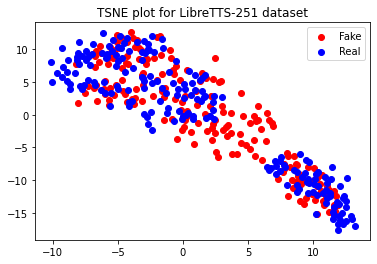

In [20]:
#res = [11,12,21,44,62,56]
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
X_train_new=(X_train[:,res])
X_test_new=X_test[:,res]
# x_fake = X_trainF
# x_real = X_trainO
x_fake = X_trainF[:,res]
x_real = X_trainO[:,res]
tsne = TSNE(n_components=2,perplexity=30,random_state=42)
x_tsne_fake = tsne.fit_transform(x_fake)
x_tsne_real = tsne.fit_transform(x_real)
plt.title("TSNE plot for LibreTTS-251 dataset")
plt.scatter(x_tsne_fake[:,0],x_tsne_fake[:,1],label="Fake",c="r")
plt.scatter(x_tsne_real[:,0],x_tsne_real[:,1],label="Real",c="b")
plt.legend()
plt.show()



In [21]:
print(np.shape(X_train_new))
print(np.shape(X_test_new))

(383, 87)
(42, 87)


### Random Forest

In [22]:
pipe1 = Pipeline([ ('std', StandardScaler()), ('Random_forest', RandomForestClassifier(n_estimators = 100))], verbose = True)
 
# fitting the data in the pipe
pipe1.fit(X_train_new, y_train)
 
# scoring data
print(accuracy_score(y_test, pipe1.predict(X_test_new)))
# prob_score1_1=pipe1.predict_proba(X_test_new)[:,1]
# prob_score1_0=pipe1.predict_proba(X_test_new)[:,0]
# print(prob_score1_1)
# print(prob_score1_0)
prob_score_RF=pipe1.predict_proba(X_test_new)
#print(prob_score_RF)


[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.3s
0.8809523809523809


#### Confusion Matrix

In [23]:
print(sklearn.metrics.confusion_matrix(y_test, pipe1.predict(X_test_new)))

[[21  0]
 [ 5 16]]


### Decision tree

In [24]:
pipe2 = Pipeline([ ('std', StandardScaler()), ('decision_tree', DecisionTreeClassifier())], verbose = True)
 
# fitting the data in the pipe
pipe2.fit(X_train_new, y_train)
 
# scoring data
print(accuracy_score(y_test, pipe2.predict(X_test_new)))
prob_score_DT=pipe2.predict_proba(X_test_new)
# print(prob_score_DT)

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing decision_tree, total=   0.0s
0.8571428571428571


#### Confusion Matrix

In [25]:
print(sklearn.metrics.confusion_matrix(y_test, pipe2.predict(X_test_new)))

[[21  0]
 [ 6 15]]


### SVM

In [26]:
pipe4 = Pipeline([ ('std', StandardScaler()), ('SVM', SVC(kernel='linear',probability=True) )], verbose = True)
 
# fitting the data in the pipe
pipe4.fit(X_train_new, y_train)
# model = SVC()
# scaler = StandardScaler()
# X_train_new = scaler.fit_transform(X_train_new)
# model.fit(X_train_new,y_train)
# model.score(X_train_new,y_train)

# scoring data
print(accuracy_score(y_test, pipe4.predict(X_test_new)))
prob_score_SVM=pipe4.predict_proba(X_test_new)
print(classification_report(y_test,pipe4.predict(X_test_new)))
# print(prob_score_SVM)

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing SVM, total=   0.0s
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        21

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



#### Confusion matrix

In [27]:
print(sklearn.metrics.confusion_matrix(y_test, pipe4.predict(X_test_new)))

[[21  0]
 [ 0 21]]


### Logistic regression

In [28]:
pipe5 = Pipeline([ ('std', StandardScaler()), ('Logistic_Regression', LogisticRegression(random_state = 0) )], verbose = True)
 
# fitting the data in the pipe
pipe5.fit(X_train_new, y_train)

# scoring data
print(accuracy_score(y_test, pipe5.predict(X_test_new)))
prob_score_LR=pipe5.predict_proba(X_test_new)
# print(prob_score_LR)

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline]  (step 2 of 2) Processing Logistic_Regression, total=   0.0s
1.0


In [29]:
print(sklearn.metrics.confusion_matrix(y_test, pipe5.predict(X_test_new)))

[[21  0]
 [ 0 21]]


### Probability Score Combination

In [30]:
from xlwt import Workbook
wb = Workbook()
sheet1 = wb.add_sheet('Sheet 1')
value = 10
count = 0
for a in range(value+1):
    for b in range(value+1):
        for c in range(value+1):
            for d in range(value+1):
                if (a+b+c+d) == value:
                    prob_score = []
                    y_pred = []
                    for i in range(42):
                        score_0 = (a*prob_score_RF[i][0])+(b*prob_score_DT[i][0])+(c*prob_score_SVM[i][0])+(d*prob_score_LR[i][0])
                        score_1 = (a*prob_score_RF[i][1])+(b*prob_score_DT[i][1])+(c*prob_score_SVM[i][1])+(d*prob_score_LR[i][1])
                        score = [score_0*(1/value),score_1*(1/value)]
                        prob_score.append(score)
                        if score_0 > score_1:
                            y_pred.append(0)
                        else:
                            y_pred.append(1)
                    #print(classification_report(y_test,y_pred))
                    sheet1.write(count+1,0,a/value)
                    sheet1.write(count+1,1,b/value)
                    sheet1.write(count+1,2,c/value)
                    sheet1.write(count+1,3,d/value)
                    sheet1.write(count+1,4,accuracy_score(y_test,y_pred))
                    count = count + 1
wb.save("c_251_84.xls")


                    

### Build graph for SVM for individual feature

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.2s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.2s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.2s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.1s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.2s
[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=   0.2s
[Pipel

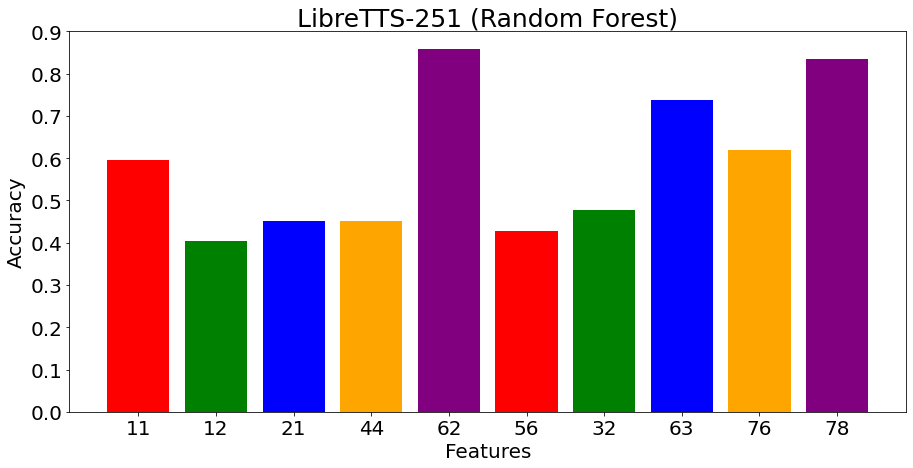

In [36]:
import matplotlib.pyplot as plt
X_axis = ['11', '12', '21', '44', '62', '56', '32', '63', '76', '78']
Y_axis = []

pipe10 = Pipeline([ ('std', StandardScaler()), ('Random_forest', RandomForestClassifier(n_estimators = 100))], verbose = True)
features = [11, 12, 21, 44, 62, 56, 32, 63, 76, 78]
for i in features:
    X_new = X_train[:,[i]]
    pipe10.fit(X_new, y_train)
    X_t_new = X_test[:,[i]]
    Y_axis.append(accuracy_score(y_test, pipe10.predict(X_t_new)))

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)
plt.title("LibreTTS-251 (Random Forest)",fontdict={'fontsize': 25})
plt.xlabel("Features",fontdict={'fontsize': 20})
plt.ylabel("Accuracy",fontdict={'fontsize': 20})
plt.bar(X_axis,Y_axis,color=[ 'red', 'green', 'blue', 'orange','purple'])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()